In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import re as regex

from matplotlib import pyplot as plt
from IPython import display

In [3]:
MODEL = './models/T1_2_FLAIR_cor/ckpt-55'

In [42]:
FLAIRPATH = '/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/FLAIR/'
T1PATH ='/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/T1/'
FLAIR_PADDING_PATH='/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/FLAIR_paddings/'
T1_PADDING_PATH='/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/T1_paddings/'

OUTPATH='/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/synth_FLAIR/'

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
INPUT_CHANNELS = 7
if INPUT_CHANNELS % 2 == 0:
    print('Even no. of slices not supported, setting INPUT_CHANNELS to ',INPUT_CHANNELS+1)
    INPUT_CHANNELS += 1

In [6]:
def file_exists(image_file,slicenum,slice_of_interest):
    return tf.io.gfile.exists(tf.strings.regex_replace(image_file,slicenum,str(slice_of_interest.numpy()).zfill(3)+'.').numpy())

def load_padding(padding_path,subjid,first):
    if first:
        return tf.io.read_file(padding_path+subjid+'_first_mean_padding.png')
    else:
        return tf.io.read_file(padding_path+subjid+'_last_mean_padding.png')
    
def load_curr_slice(image_file,slicenum,curr_slice):
    return tf.io.read_file(tf.strings.regex_replace(image_file,slicenum,str(curr_slice.numpy()).zfill(3)+'.'))

def load(image_file):

  real_image_file=tf.strings.regex_replace(image_file,T1PATH,FLAIRPATH)
  #create 3D image stack for multi-channel input with mean padding
  #input_imagelist,real_imagelist = tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS), tf.float32), tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS), tf.float32)    
  input_imagelist = tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS), tf.float32)
  slicenum="([0-9]{3})\."
  subjid=tf.strings.split(tf.strings.split(image_file,sep='/')[-1],sep='_')[0]
  mid_slice=int(tf.strings.substr(image_file, -7, 3))
  halfstack = lo_idx = hi_idx = INPUT_CHANNELS//2
  min_slice=mid_slice-lo_idx
  max_slice=mid_slice+hi_idx
  num_curr_slice=0


  while not tf.py_function(file_exists,[image_file, slicenum, min_slice],Tout=tf.bool):
    lo_idx -= 1
    min_slice +=1

  while not tf.py_function(file_exists,[image_file, slicenum, max_slice],Tout=tf.bool):
    hi_idx -=1
    max_slice -=1

  if halfstack-lo_idx != 0:
    
    #input_image = tf.io.read_file(T1_PADDING_PATH+subjid+'_first_mean_padding.png')
    input_image = tf.py_function(load_padding, [T1_PADDING_PATH,subjid,True],Tout=tf.string)
    input_image = tf.image.decode_png(input_image,channels=1)
    input_image = tf.image.convert_image_dtype(input_image, tf.float32) 
    
#     real_image = tf.py_function(load_padding, [FLAIR_PADDING_PATH,subjid,True],Tout=tf.string)
#     real_image = tf.image.decode_png(real_image,channels=1)
#     real_image = tf.image.convert_image_dtype(real_image, tf.float32) 
    
    for i in range(halfstack-lo_idx): 
      input_imagelist=tf.concat([input_imagelist[...,:num_curr_slice], 
                                 input_image, tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS-num_curr_slice-1), 
                                                       tf.float32)], axis=2)
#       real_imagelist=tf.concat([real_imagelist[...,:num_curr_slice], 
#                                 real_image, tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS-num_curr_slice-1), 
#                                                      tf.float32)], axis=2)
      num_curr_slice += 1
    
      input_imagelist.set_shape([IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS])
#       real_imagelist.set_shape([IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS])
    
  for curr_slice in range(min_slice, max_slice+1):
    
    #input_image = tf.io.read_file(tf.strings.regex_replace(image_file,slicenum,str(curr_slice).zfill(3)+'.'))
    input_image = tf.py_function(load_curr_slice, 
                                 [image_file,slicenum,curr_slice], 
                                 Tout=tf.string)
    input_image = tf.image.decode_png(input_image,channels=1)
    input_image = tf.image.convert_image_dtype(input_image, tf.float32) 
    
    #real_image = tf.io.read_file(tf.strings.regex_replace(real_image_file,slicenum,str(curr_slice).zfill(3)+'.'))
#     real_image = tf.py_function(load_curr_slice, 
#                                 [real_image_file,slicenum,curr_slice], 
#                                 Tout=tf.string)
#     real_image = tf.image.decode_png(real_image,channels=1)
#     real_image = tf.image.convert_image_dtype(real_image, tf.float32) 
    
    
    input_imagelist=tf.concat([input_imagelist[...,:num_curr_slice], 
                               input_image, tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS-num_curr_slice-1), 
                                                     tf.float32)], axis=2)
#     real_imagelist=tf.concat([real_imagelist[...,:num_curr_slice], 
#                               real_image, tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS-num_curr_slice-1), 
#                                                    tf.float32)], axis=2)
    num_curr_slice += 1
    
    input_imagelist.set_shape([IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS])
#     real_imagelist.set_shape([IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS])    
                                      
  if halfstack-hi_idx != 0:
    
    input_image = tf.py_function(load_padding, [T1_PADDING_PATH,subjid,False],Tout=tf.string)
    input_image = tf.image.decode_png(input_image,channels=1)
    input_image = tf.image.convert_image_dtype(input_image, tf.float32) 

    
#     real_image = tf.py_function(load_padding, [FLAIR_PADDING_PATH,subjid,False],Tout=tf.string)
#     real_image = tf.image.decode_png(real_image,channels=1)
#     real_image = tf.image.convert_image_dtype(real_image, tf.float32) 
    
    for i in range(halfstack-hi_idx): 
      input_imagelist=tf.concat([input_imagelist[...,:num_curr_slice], 
                                 input_image, tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS-num_curr_slice-1), 
                                                       tf.float32)], axis=2)
#       real_imagelist=tf.concat([real_imagelist[...,:num_curr_slice], 
#                                 real_image, tf.zeros((IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS-num_curr_slice-1), 
#                                                      tf.float32)], axis=2)
      num_curr_slice += 1
      input_imagelist.set_shape([IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS])
#       real_imagelist.set_shape([IMG_WIDTH, IMG_HEIGHT, INPUT_CHANNELS])
      
  real_image = tf.io.read_file(real_image_file)
  real_image = tf.image.decode_png(real_image, channels=1)
  real_image = tf.image.convert_image_dtype(real_image, tf.float32)
  
#   return input_imagelist, real_imagelist
  return input_imagelist, real_image

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [9]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [24]:
test_dataset = tf.data.Dataset.list_files(T1PATH+'test/*.png', shuffle=False)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
OUTPUT_CHANNELS = 1

In [12]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [13]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [14]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,INPUT_CHANNELS])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [15]:
generator = Generator()

In [16]:
LAMBDA = 100

In [17]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [18]:
discriminator = Discriminator()

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

In [20]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [39]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))
  display_list = [test_input[0,...,INPUT_CHANNELS//2,tf.newaxis], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i][:,:,0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.show()
  return prediction[0]

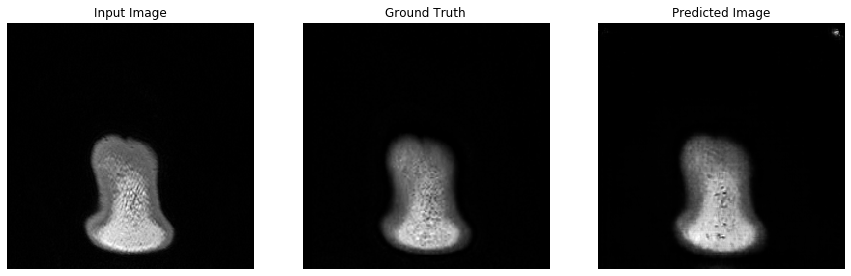

tf.Tensor(b'/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/synth_FLAIR/test/10649_slice005.png', shape=(), dtype=string)


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'write'

In [48]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(MODEL)

# Run the trained model on a few examples from the test dataset
for (inp, tar), path in zip(test_dataset.take(5),tf.data.Dataset.list_files(T1PATH+'test/*.png',shuffle=False).take(5)):
  prediction = generate_images(generator, inp, tar)
  outfile = tf.strings.regex_replace(path,T1PATH,OUTPATH)
  print(outfile)
  tf.keras.preprocessing.image.save_img(outfile, prediction, file_format='png')

In [29]:
for i, n in enumerate(tf.data.Dataset.list_files(T1PATH+'test/*.png',shuffle=False).take(5)):
    tf.print(n)

/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/T1/test/10649_slice005.png
/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/T1/test/10649_slice006.png
/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/T1/test/10649_slice007.png
/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/T1/test/10649_slice008.png
/home/bdavid/Deep_Learning/playground/fake_flair_2d/png_cor/T1/test/10649_slice009.png
